This notebook demonstrates using the realizable softmax parametrization for the loss function. More detailed descriptions of the code can be found in `mnist_demo.ipynb`.

In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

In [2]:
import torch
import torch.optim as optim
from model import LogisticRegressionModule
from data import get_dataloaders
from l2d_functionality.l2d_loss import L2D_Loss
from l2d_functionality.l2d_eval import L2D_Eval
import numpy as np
import matplotlib.pyplot as plt

Define hyperparameters, including `tau` and `alpha` used by realizable softmax. 

`alpha` is a hyperparameter between 0 and 1 (inclusive), used in the loss function to weigh the relative importance of using expert labels and the classifier. Due to adding this parameter, the loss is no longer realizable consistent, so the rejector $r(x) =
\begin{cases} 
1 & \text{if } g_{\perp}(x) - \max_y g_y(x) \geq \tau \\
0 & \text{otherwise}
\end{cases}$
 is used, where `tau` ($\tau$) is another hyperparameter. 

In [3]:
input_dim = 28 * 28
num_classes = 10
learning_rate = 0.00005
num_epochs = 5
l2_lambda = 0.5
expert_prob = 0.9
tau = 0.5
alpha = 0.6 # in range [0, 1]

In [4]:
output_dim = num_classes + 1
deferral_class_index = num_classes

In [5]:
# load data

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from data import ExpertMNIST

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.Lambda(lambda tensor: torch.flatten(tensor)) # Flatten the tensor
])

train_dataset_raw = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset_raw = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

expert = ExpertMNIST(expert_prob)

expert_labels_train = torch.tensor([expert.expert_prediction(label) for _, label in train_dataset_raw])
expert_labels_test = torch.tensor([expert.expert_prediction(label) for _, label in test_dataset_raw])

In [6]:
model = LogisticRegressionModule(input_dim, output_dim, deferral_class_index, l2_lambda)
train_loader, test_loader = get_dataloaders(train_dataset_raw, expert_labels_train, test_dataset_raw, expert_labels_test)

In [7]:
l2d = L2D_Loss(num_classes)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
losses = []

for epoch in range(int(num_epochs)):

    for images, labels, expert_labels_batch in train_loader:
        outputs = model(images)
        
        loss = l2d.loss_fn(outputs, labels, expert_labels_batch, deferral_class_index, "realizable_sm", alpha)

        loss += model.l2_regularization()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())


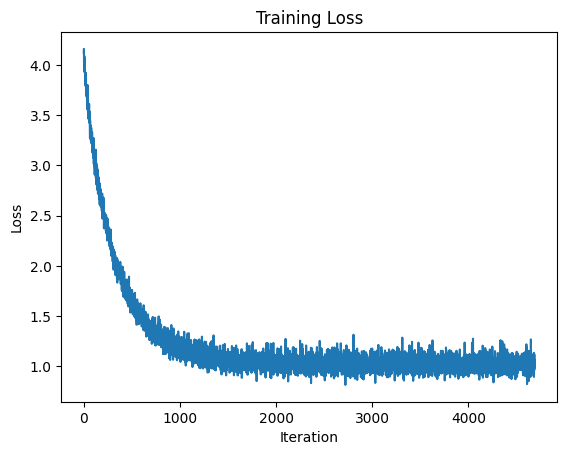

In [8]:
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.savefig("training_loss.png")

In evaluation, set the `realizable_sm` flag to True to ensure the rejector is used.

Test Accuracy of Regular Classifier: 83.57%
Test Accuracy (excluding deferrals): 88.16%
Deferral Accuracy: 84.31%
Overall Deferral Rate: 29.83%
Overall L2D Accuracy: 87.01%
Class 0: Accuracy (non-deferred) = 98.02%, Deferral Rate = 2.14%, Overall Accuracy = 95.92%
Class 1: Accuracy (non-deferred) = 97.09%, Deferral Rate = 9.07%, Overall Accuracy = 96.74%
Class 2: Accuracy (non-deferred) = 86.50%, Deferral Rate = 4.55%, Overall Accuracy = 82.56%
Class 3: Accuracy (non-deferred) = 89.21%, Deferral Rate = 42.18%, Overall Accuracy = 90.50%
Class 4: Accuracy (non-deferred) = 97.14%, Deferral Rate = 10.90%, Overall Accuracy = 86.56%
Class 5: Accuracy (non-deferred) = 46.20%, Deferral Rate = 58.74%, Overall Accuracy = 74.66%
Class 6: Accuracy (non-deferred) = 92.10%, Deferral Rate = 0.94%, Overall Accuracy = 91.23%
Class 7: Accuracy (non-deferred) = 73.33%, Deferral Rate = 76.65%, Overall Accuracy = 91.54%
Class 8: Accuracy (non-deferred) = 91.09%, Deferral Rate = 19.30%, Overall Accuracy = 7

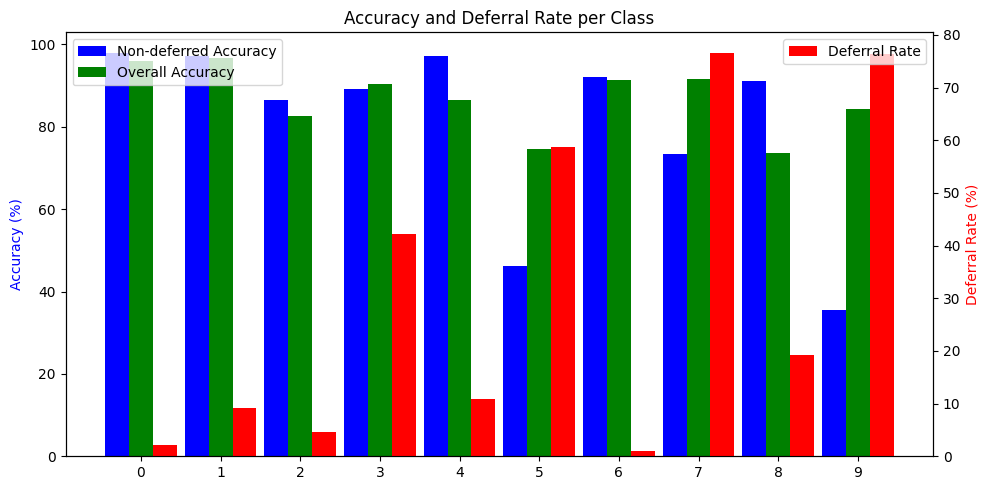

In [ ]:
all_outputs = []
all_labels = []
all_expert_labels = []

with torch.no_grad():
    for images, labels, expert_labels in test_loader:

        outputs = model(images)
        
        all_outputs.append(outputs)
        all_labels.append(labels)
        all_expert_labels.append(expert_labels)

all_outputs = torch.cat(all_outputs, dim=0)
all_labels = torch.cat(all_labels, dim=0)
all_expert_labels = torch.cat(all_expert_labels, dim=0)

l2d_eval = L2D_Eval(num_classes, all_outputs, all_labels, all_expert_labels, deferral_class_index, realizable_sm=True, tau=tau)

model_report = l2d_eval.model_report()
per_class_report = l2d_eval.per_class_report()
l2d_eval.visualize_per_class_metrics()